In [1]:
from random import shuffle, randint
import os

import nbtlib

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

device = 'cuda' if torch.cuda.is_available() else 'cpu'

**Data preprocessing**

In [2]:
class Schematic:
    def __init__(self, width, height, length, blocks):
        self.width = nbtlib.tag.Short(width)
        self.height = nbtlib.tag.Short(height)
        self.length = nbtlib.tag.Short(length)

        self.blocks = self.nbt_blocks(blocks)
        self.data = self.nbt_data(width * height * length)

    def nbt_blocks(self, blocks):
        b_arr = nbtlib.tag.ByteArray([nbtlib.tag.Byte(block) for block in blocks])
        return b_arr
    
    def nbt_data(self, dimension):
        b_arr = nbtlib.tag.ByteArray([nbtlib.tag.Byte(0) for _ in range(dimension)])
        return b_arr
    
    def __call__(self, path):
        file = nbtlib.load(path)
        
        file['Width'] = self.width
        file['Height'] = self.height
        file['Length'] = self.length
        file['Blocks'] = self.blocks
        file['Data'] = self.data

        file['WEOffsetX'] = nbtlib.tag.Int(0)
        file['WEOffsetY'] = nbtlib.tag.Int(0)
        file['WEOffsetZ'] = nbtlib.tag.Int(0)
        file['WEOriginX'] = nbtlib.tag.Int(0)
        file['WEOriginY'] = nbtlib.tag.Int(0)
        file['WEOriginZ'] = nbtlib.tag.Int(0)
        file['Materials'] = nbtlib.tag.String('Alpha')

        file.save()

In [3]:
# Convert .schematic to 3d tensor
def schematic_to_tensor(path):
    file = nbtlib.load(path)
    metadata = (int(file['Height']), int(file['Length']), int(file['Width']),)
    tensor = torch.tensor(file['Blocks']).reshape(metadata)
    return tensor

In [9]:
r_path = r"Directory where your .schematic are stored"
dummy = schematic_to_tensor(r_path)

torch.Size([28, 28, 28])

In [4]:
# Get all .schematic paths from a directory
def get_all_paths(directory):
    all_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            all_paths.append(os.path.join(root, file))
    all_paths = [path.split(r"Pack")[-1][1:] for path in all_paths if '.schematic' in path]
    return all_paths

In [5]:
# Pad 3d tensor to a fixed target shape
def pad_to_fixed_shape(tensor, target_shape=32):
    pad_x = target_shape - tensor.shape[0]
    pad_y = target_shape - tensor.shape[1]
    pad_z = target_shape - tensor.shape[2]

    padding = (
        pad_z - pad_z//2, pad_z//2,
        pad_y - pad_y//2, pad_y//2, 
        pad_x - pad_x//2, pad_x//2,
    )

    tensor = F.pad(tensor, padding, 'constant')

    return(tensor)

In [5]:
# Convert negative n's inside tensor into 127 - n
def convert_negatives(tensor):
    mask = tensor < 0

    positive_counterparts = tensor.abs()

    transformed_tensor = torch.where(mask, 127 + positive_counterparts, tensor)

    return transformed_tensor

# Convert n's > 127 inside tensor to 127 - n
def convert_negatives_back(tensor):
    mask = tensor > 127

    transformed_tensor = torch.where(mask, 127 - tensor, tensor)

    return transformed_tensor

DataLoader without labels

In [6]:
# DataLoader without labels
def get_loader(directory_path: str, split_p: float = 0.8, shape_limit: int = 32, batch_size: int = 32) -> DataLoader:
    all_paths = get_all_paths(directory_path)
    
    houses = list()
    for path in all_paths:
        try:
            tensor = schematic_to_tensor(path)
        except:
            continue
        if all(tensor.shape[i] <= shape_limit for i in range(3)):
            normalized_tensor = pad_to_fixed_shape(tensor, shape_limit).to(torch.int64).to(device)
            normalized_tensor = convert_negatives(normalized_tensor)
            houses.append(normalized_tensor)

    split = int(len(houses) * split_p)
        
    trainloader = DataLoader(houses[:split], batch_size=batch_size, shuffle=True)
    testloader = DataLoader(houses[split:], batch_size=batch_size, shuffle=False)
    return trainloader, testloader, houses

In [16]:
train_path = r"Directory where your .schematic for training are stored"
trainloader, testloader, checklist = get_loader(train_path, .8, shape_limit=28)
print(f'Checklist has {len(checklist)} elements')
print(f'Trainloader has {len(trainloader)} batches')
print(f'Testloader has {len(testloader)} batches')

Checklist has 947 elements
Trainloader has 24 batches
Testloader has 6 batches


DataLoader with labels

In [8]:
# DataLoader with labels
def get_list(directory_path: str, shape_limit: int = 32) -> list:
    all_paths = get_all_paths(directory_path)
    
    houses = list()
    for path in all_paths:
        tensor = schematic_to_tensor(path)
        if all(tensor.shape[i] <= shape_limit for i in range(3)):
            normalized_tensor = pad_to_fixed_shape(tensor, shape_limit).to(torch.int64).to(device)
            normalized_tensor = convert_negatives(normalized_tensor)
            houses.append(normalized_tensor)

    # shuffle(houses)
    return houses

def label_houses(houses: list, label: int) -> list:
    labeled_houses = zip(
        houses,
        [label for _ in range(len(houses))]
    )
    return list(labeled_houses)

def lists_to_loader(lists, batch_size: int = 1, train: bool = True) -> DataLoader:
    all_lists = []
    for houses in lists:
        all_lists += houses
    loader = DataLoader(all_lists, batch_size=batch_size, shuffle=train)
    return loader


In [200]:
### Generate train DataLoader

# Training paths
train_paths = [
    ...
]

# Some functions
train_lists = [get_list(path) for path in train_paths]

for i, train_list in enumerate(train_lists, 1):
    print(f"List #{i} has {len(train_list)} valid samples")

# Training slice and labels
train_slices_labels = [
    (slice(0, -1), 1),
    (slice(0, -1), 0),
]

# Other functions
train_labeled_lists = [label_houses(train_list[cut], label)
                  for train_list, (cut, label) in zip(train_lists, train_slices_labels)]

trainloader = lists_to_loader(train_labeled_lists, 1)

List #1 has 321 valid samples
List #2 has 23 valid samples


In [10]:
### Generate validation DataLoader

# Validation paths
validation_paths = [
    ...
]

# Some functions
validation_lists = [get_list(path) for path in validation_paths]

for i, validation_list in enumerate(validation_lists, 1):
    print(f"List #{i} has {len(validation_list)} valid samples")

# Validation slice and labels
validation_slices_labels = [
    (slice(20, 26), 1),
    (slice(20, 23), 0),
]

# Other functions
validation_labeled_lists = [label_houses(validation_list[cut], label)
                  for train_list, (cut, label) in zip(validation_lists, validation_slices_labels)]

valloader = lists_to_loader(validation_labeled_lists, 1)

List #1 has 26 valid samples
List #2 has 23 valid samples


In [71]:
# This part of code is used to export tensors to .schematic
example = dummy
export = Schematic(*example.shape, example.reshape(-1).tolist())
path = r"Path to .schematic file"
export(path)

**Visualize**

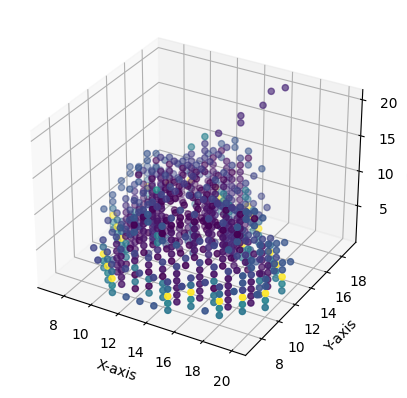

In [14]:
id_ = int(input())
tensor_data = checklist[id_]

# Filter out the zero values
non_zero_mask = tensor_data != 0
non_zero_values = tensor_data[non_zero_mask]

# Create a meshgrid of 3D coordinates for each element in the tensor
x, y, z = torch.meshgrid(torch.arange(tensor_data.shape[0]),
                         torch.arange(tensor_data.shape[1]),
                         torch.arange(tensor_data.shape[2]))

# Flatten the tensor and meshgrid coordinates for plotting
x = x[non_zero_mask].numpy()
y = y[non_zero_mask].numpy()
z = z[non_zero_mask].numpy()

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set the data points as a scatter plot
ax.scatter(z, y, x, c=non_zero_values, cmap='viridis', marker='o')

# Set axis labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Show the plot
plt.show()

**Model**

In [30]:
class Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, n_hidden):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.conv = nn.Sequential(
            nn.Conv3d(embed_dim, embed_dim * 2, (5, 5, 5)),
            nn.BatchNorm3d(embed_dim * 2),
            nn.ReLU(),
            nn.MaxPool3d(2),

            nn.Conv3d(embed_dim * 2, embed_dim * 4, (5, 5, 5)),
            nn.BatchNorm3d(embed_dim * 4),
            nn.ReLU(),
            nn.MaxPool3d(2),
        )

        self.out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(embed_dim * 4 * 4**3, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 6),
        )


    def forward(self, x):
        x = self.embedding(x).permute(0, 4, 1, 2, 3)
        x = self.conv(x)
        x = self.out(x)
        return x

In [31]:
VOCAB_SIZE = 256
EMBED_DIM = 16
N_HIDDEN = 1024 

In [32]:
model = Model(VOCAB_SIZE, EMBED_DIM, N_HIDDEN)

In [33]:
transforms = [
    (0, 1, 2), # 0
    (0, 2, 1), # 1
    (1, 0, 2), # 2
    (1, 2 ,0), # 3
    (2, 0, 1), # 4
    (2, 1, 0), # 5
]

In [34]:
def apply_permutation(batch_tensor):
    '''Applies permutation and returns permutation's labels'''
    batch_size, *_ = batch_tensor.shape
    permuted_tensors = []
    labels = []

    # Iterate through each element in the batch
    for i in range(batch_size):
        # Get the current permutation for this element in the batch
        randint_ = randint(0, 5)
        permutation = transforms[randint_]
        # Apply the permutation to the tensor
        permuted_tensor = batch_tensor[i].permute(*permutation)
        permuted_tensors.append(permuted_tensor)
        labels.append(torch.tensor(randint_))

    # Concatenate the permuted tensors along the batch dimension
    permuted_batch = torch.stack(permuted_tensors)
    labels_batch = torch.stack(labels)
    return permuted_batch, labels_batch


In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

In [ ]:
epochs = 10

for epoch in range(1, epochs+1):
    model.train()

    LOSS = 0
    accuracy = 0

    for input_ in trainloader:
        features, labels = apply_permutation(input_)

        optimizer.zero_grad()

        logits = model(features)

        loss = criterion(logits, labels)
        loss.backward()

        optimizer.step()

        LOSS += loss.item()

        acc = sum((torch.argmax(logits, -1) == labels).to(torch.int).tolist())
        accuracy += acc / input_.size(0)
    
    accuracy /= len(trainloader) 
    LOSS /= len(trainloader)
    
    print(f'Epoch {epoch}/{epochs}')
    print(f'Train loss: {LOSS:.6f}')
    print(f'Train acc: {accuracy:.2f}')

    LOSS = 0
    accuracy = 0

    model.eval()
    with torch.inference_mode():
        for input_ in testloader:
            features, labels = apply_permutation(input_)

            logits = model(features)

            loss = criterion(logits, labels)

            LOSS += loss.item()

            acc = sum((torch.argmax(logits, -1) == labels).to(torch.int).tolist())
            accuracy += acc / input_.size(0)

    accuracy /= len(testloader) 
    LOSS /= len(testloader)

    print(f'Val loss: {LOSS:.6f}')
    print(f'Val acc: {accuracy:.2f}')


In [ ]:

model.eval()

LOSS = 0
accuracy = 0
total = 0

loader = testloader # select

with torch.inference_mode():
    for input_ in loader:
        features, labels = apply_permutation(input_)
        
        logits = model(features)

        loss = criterion(logits, labels)
        LOSS += loss.item()

        acc = sum((torch.argmax(logits, -1) == labels).to(torch.int).tolist())
        accuracy += acc / input_.size(0)

        print(f'labels: {labels.tolist()}')
        print(f'preds:  {torch.argmax(logits, -1).tolist()}')
        print(f'acc:    {acc * 100 / input_.size(0):.2f}')


    accuracy /= len(loader) 
    LOSS /= len(loader)

    print(f'{accuracy*100:.2f}')
    print(f'{LOSS:.6f}')